## Sensitivity Sampling and Analysis

This notebook demonstrates the use of the AWRAMS clustering/calibration system for Sobol Sequence sampling of the model, and associated tools for sensitivity analysis of the outputs

This notebook goes through the following steps:

1. Import required libraries
2. Set up calibration configuration <br>
 2.1 Catchments to be calibrated<br>
 2.2 Period to calibrate over<br>
 2.3 Import model/get default mapping<br>
 2.4 Setting the optimizer - SobolOptimizer<br>
 2.5 Define objective functions<br>
 2.6 Update forcing paths (optional)<br>
 2.7 Combine into a specification dictionary<br>
3. Run 'calibration'; ie sampling<br>
4. Visualise sensitivity outputs

### 1. Import required libraries

In [1]:
from awrams.calibration.support import *
from os.path import join
from awrams.utils import gis
from awrams.utils import datetools as dt
from awrams.utils import extents
from awrams.utils.settings_manager import get_settings
import h5py

### 2. Define calibration configuration

#### 2.1 Select catchment extents

In [2]:
# Point to some catchment data

from awrams.utils.gis import ShapefileDB, CATCHMENT_SHAPEFILE

calvalshapefile = ShapefileDB(CATCHMENT_SHAPEFILE)

# Define the extenst of the calibration
def_extent = extents.get_default_extent() 

In [3]:
 ## Create a dict with multiple extents
extent_map = {}
cal_catchments = ['109001','111101','112102']

for catchment in cal_catchments:
    extent_map[catchment] = calvalshapefile.get_extent_by_field('StationID', catchment, parent_extent=def_extent)
    
extent_map

{'109001': origin: -16.4,145.2, shape: (3, 5), cell_size: 0.05,
 '111101': origin: -17.35,145.7, shape: (4, 8), cell_size: 0.05,
 '112102': origin: -17.65,145.8, shape: (4, 3), cell_size: 0.05}

#### 2.2 Specify running period

In [4]:
run_period = dt.dates('2009 - 2011')
eval_period = dt.dates('2009 - 2011')

#### 2.3 Import model/get default mapping

In [5]:
# Import the model

from awrams.models.awral.model import AWRALModel
from awrams.utils.nodegraph import nodes, graph


model = AWRALModel()
node_mapping = model.get_default_mapping()

#### 2.4 Specify the optimizer

In [6]:
# Use the SobolOptimizer class to generate Sobol sequence samples

from awrams.calibration.sensitivity import SobolOptimizer

# Set termination conditions - 3000 max evaluations is not really a 'proper' run, but will be enough to see some results...
# Threshold is the convergence threshold for the sum of estimated sensitivities; ie the run should terminate once
# these values stabilise
optimizer_spec = OptimizerSpec(SobolOptimizer,threshold = 0.01,max_eval = 3000)


#### 2.5 Set up objective functions<br>
When used with a sampling optimizer (eg Sobol), objective functions are not directly opimized on, but are still needed in order to obtain logging of the results

In [7]:
from awrams.calibration.objectives import test_objectives as tobj

# Our 'objective functions' (ie what gets stored in the logfile)
# are volume totals of water balance outputs; runoff, et, and deep drainage

local_objfspec = ObjectiveFunctionSpec(tobj.LocalQTotal)
global_objfspec = tobj.GlobalQTotal

observations = {}

objective_spec = ObjectiveSpec(global_objfspec,local_objfspec,observations,eval_period)


####2.7 Build spec dict

Assemble above settings into specification dictionary

In [8]:
'''
User specifiable calibration description
'''
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = extent_map
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
#cal_spec['logfile'] = '/short/er4/dss548/calibration_res.h5'
cal_spec['logfile'] = './sobolres4.h5'

#cal_spec['prerun_action'] = callable_to_funcspec(prerun_raijin)
#cal_spec['postrun_action'] = callable_to_funcspec(postrun_raijin)



### 3. Run the calibration

In [9]:
from awrams.calibration import cluster
_ = cluster.build_pickle_from_spec(cal_spec,1,'test_sens.pkl')

In [10]:
from awrams.calibration.launch_calibration import run_from_pickle
run_from_pickle('./test_sens.pkl')

s:  8092
n
[('sample_space', <class 'str'>), ('ss_iter', <class 'int'>)]

 running
{'n_eval': 0, 'cur_sens': None}
..
 running
{'n_eval': 115, 'cur_sens': 5.3628216598146323e+22}

 running
{'n_eval': 230, 'cur_sens': 3.3865726829851377e+25}

 running
{'n_eval': 345, 'cur_sens': 4.3049067584803071e+25}

 running
{'n_eval': 460, 'cur_sens': 5.2263077290812889e+25}

 running
{'n_eval': 690, 'cur_sens': 5.7656835008235796e+25}

 running
{'n_eval': 920, 'cur_sens': 6.176957928242423e+25}

 running
{'n_eval': 1150, 'cur_sens': 6.5092118795432517e+25}

 running
{'n_eval': 1265, 'cur_sens': 6.4486841748392082e+25}

 running
{'n_eval': 1380, 'cur_sens': 6.5392185712962326e+25}

 running
{'n_eval': 1495, 'cur_sens': 6.5838703970305923e+25}

 running
{'n_eval': 1610, 'cur_sens': 6.8398351539172639e+25}
..
 running
{'n_eval': 1725, 'cur_sens': 6.9600349376839188e+25}

 running
{'n_eval': 1840, 'cur_sens': 7.1309916224204447e+25}

 running
{'n_eval': 1955, 'cur_sens': 7.2374604749045116e+25}

 runn

### 4. Examine the results

Results are stored in an HDF5 file (like all AWRAMCMS calibration outputs).  SensitivityResults provides a wrapper to directly perform sensitivity analysis on the results of a SobolOptmizer run

In [11]:
from awrams.calibration import sensitivity
from matplotlib import pyplot as plt
from awrams.calibration.sensitivity import SensitivityResults

In [12]:
#Open the results

sr = SensitivityResults('./sobolres4.h5')

In [13]:
#Show the global outputs that are available

sr.global_keys

['dd_vol', 'etot_vol', 'qtot_vol']

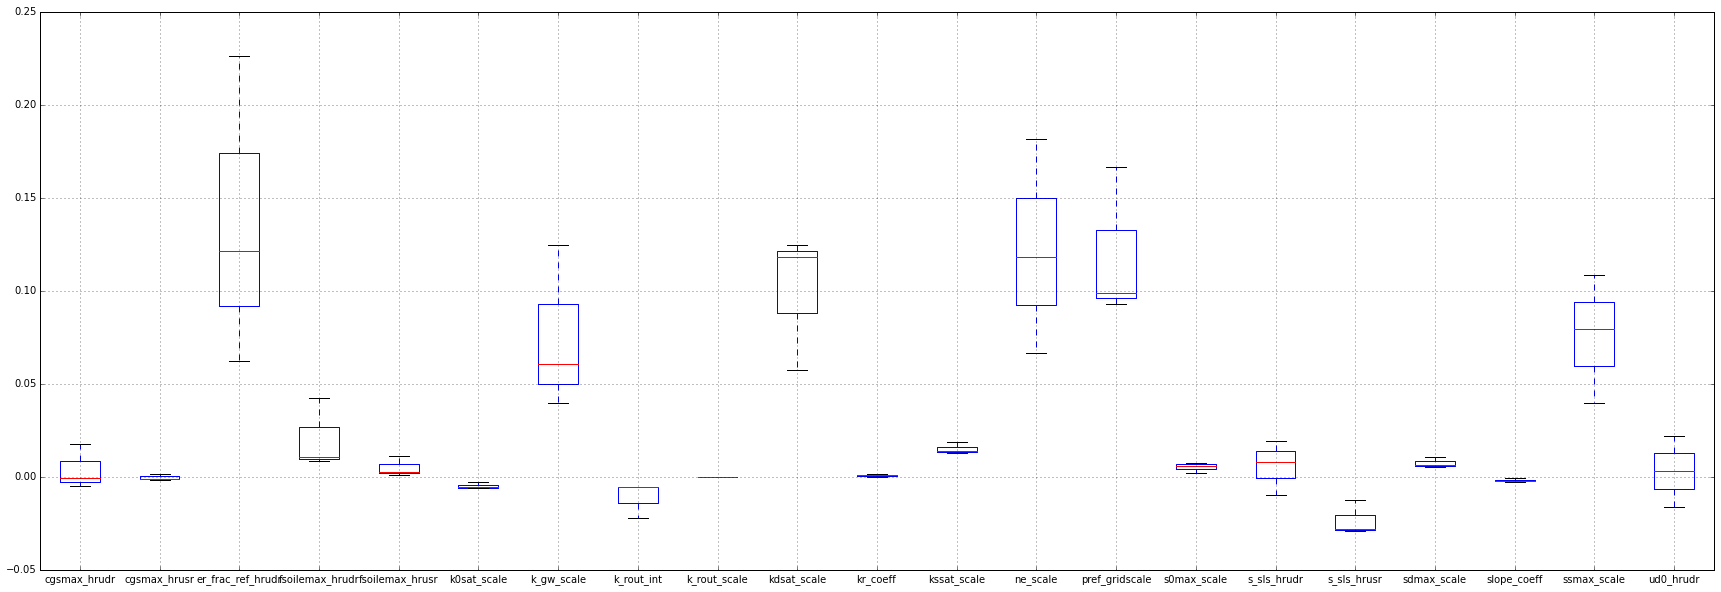

In [14]:
#Get the sensitivities for individual catchments, and plot their distribution

catchsens = sr.get_all_catchment_si('qtot_vol')
fig = plt.figure(figsize=(30,10))
bp = catchsens.astype(float).boxplot(return_type='axes')

In [15]:
#Convenience function for plotting; not part of the core code

def plot_si(sr,param,catchment=None):
    fig = plt.figure(figsize=(6,10))
    if catchment is not None:
        psens = sr.get_catchment_si(param,catchment)
        title = '%s (Si), catch_id: %s' % (param, catchment)
    else:
        psens = sr.get_global_si(param)
        title = '%s (Si), global' % param
    psens.plot(kind='barh',xlim=[0,psens.max()+0.1],title=title)
    plt.gca().invert_yaxis()
    print(sum(psens))

In [16]:
#Convenience function for plotting; not part of the core code

def plot_sti(sr,param,catchment=None):
    fig = plt.figure(figsize=(6,10))
    if catchment is not None:
        psens = sr.get_catchment_si(param,catchment,True)
        title = '%s (STi), catch_id: %s' % (param, catchment)
    else:
        psens = sr.get_global_si(param,True)
        title = '%s (STi), global' % param
    psens.plot(kind='barh',xlim=[0,psens.max()+0.1],title=title)
    plt.gca().invert_yaxis()
    print(sum(psens))

1.21603691393


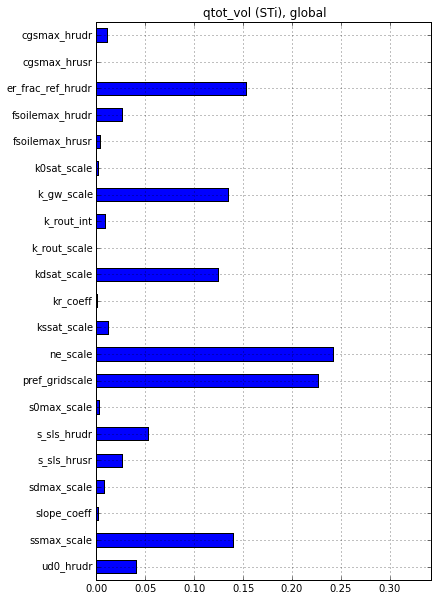

In [17]:
# Show the total sensitivity index for qtot

plot_sti(sr,'qtot_vol')

1.16821880293


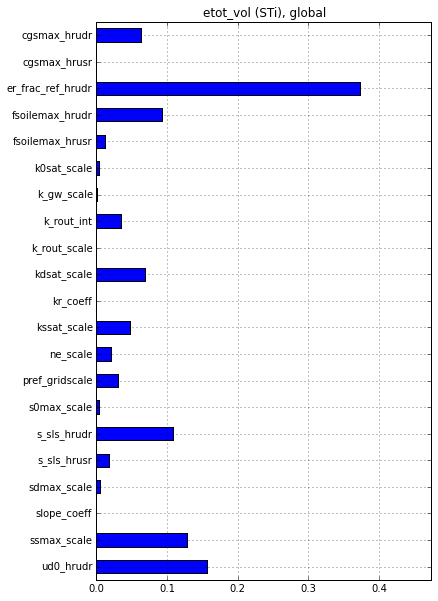

In [18]:
# Show the total sensitivity index for etot

plot_sti(sr,'etot_vol')

1.28875352927


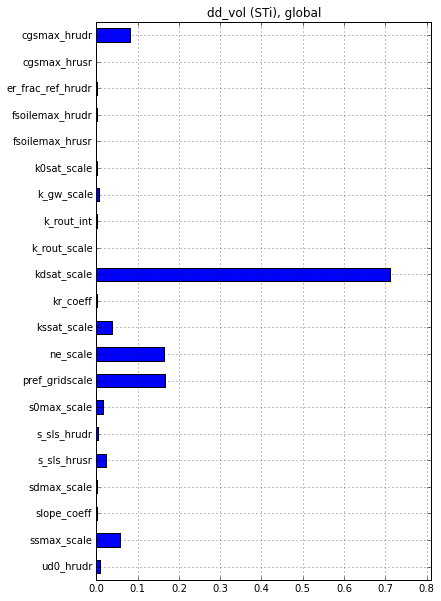

In [19]:
# Show the total sensitivity index for deep drainage

plot_sti(sr,'dd_vol')